In [1]:
import grama as gr
import pandas as pd

from boat_utils_new import *
from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline

DF = gr.Intention()

import numpy as np
from grama.fit import ft_gp, fit_gp
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# PDO Final Project: Kayak Boat Hull Optimization


## Executive Summary
Designing a boat hull can come with a broad range of design constaints and requirements depending on the desired use. One such desired outcome of a boat hull design might be the stability of the boat as it takes a wave input from one side or another. While some oscillation is inevitable, we can design a boat hull that has the minimum resulting oscillation from an input wave.  
    
This design study takes a simple model of boat hull design and extends it to answer questions about the hull shape's response to a wave input. To do this, I considered the boat to be a simple system with a gravitational force and a buoyant force. As a starting point, I built off of a model by Zach del Rosario which evaluated the torque due to buoyancy as the boat rotates around its center of mass on flat water. I extended this model to evaluate the net torque on the boat due to both the angle of the water *and* the angle of the boat. This allowed me to simulate an environment where a stationary boat is subject to an arbitrary wave input, described by the angle of the water surrounding the boat. Specifically, my goal was to *minimize* the resulting angle of the boat hull after it was subject to this wave input.  

        
## Background
Boat users come in all breeds. Wakeboarders, fisherman, commuters, and supply chain analysts all rely on boats for one reason or another. Kayaks are one kind of boat which are used commonly in recreation, in which an individual sits with their legs inside of the boat and use a paddle to propel themselves through the water.

![kayak](images/kayak0.jpg)
*image source*: https://www.australiangeographic.com.au/australian-geographic-adventure/how-to/2012/05/beginners-guide-to-sea-kayaking/

As a sea kayaking guide, I was frequently exposed to beginners getting in a kayak for the first time and experience feelings of tippiness in the water. Additionally, traveling through the harbor I found that waves created by nearby boats can be a hazard to novice kayakers who have poor balance. For this reason, boat hull designs should be explored to be made incredibly stable so that beginner kayakers can have more confidence and enjoy themselves more. Admittedly there are other pieces of the design of a kayak hull which may be important to a kayaker. For example, they may be concerned with maneuverability or resistance to motion as they move through the water. However, if we focus on a true beginner kayaker as our key stakeholder, we may assume that these needs are secondary to stability. 


## Formulation

Once again, my goal was to calculate the moment on the boat as the result of both the angle of the hull and the angle of the waterline relative to the global frame. The drawing below attempts to illustrate why this is important. As the water rotates around the hull, the center of buoyanacy changes and the direction of the buoyant vector changes as well. Buoyancy is always normal to the surface of the water. In this diagram, $\theta_b$ is the the angle of the boat and $\theta_w$ is the angle of the waterline. 

![buoyancy](images/buoyancy.jpg)




For a given hull shape, I then calculated the resulting moment on the boat at various values of $\theta_b$ and $\theta_w$. This turned out to be a rather costly calculatio, but my knowledge of Gaussian Processes (GP) came in quite useful here. I fitted a GP to the two angle input variables to calculate the resulting moment, which allowed me to easily evaluate the moment for any given angle later on. 

To do something with this moment curve, I used it in the context of a simulation. The simulation was aimed at recreating the effect of a rogue wave on a passive boat hull. The equation of the wave which I studied is described in the function `w_func(t)`, where t is the time variable. For a preset range of timesteps, the torque on the boat and resulting angular postion of the boat is calculated using a standard form for the motion of a rotating object using an arbitrary viscous drag term `b`. The specific value for this drag constant was chosen at random, and does not necessarily reflect reality. 

$$ \ddot\theta_b J = \Sigma \tau$$

where J is the moment of rotational inertia.  

After running the simulation across sufficient time steps, I recorded the maximum angle $\theta_{max}$ that the boat reached across *all* time steps. In the context of a novice kayaker, a smaller $\theta_{max}$ is desired because it means that with no control, the boat oscillates less, which translates to more stability and more comfort. 

Finally, the simple hull model used allowed me to sweep a specific parameter to learn what hull shape gives the smallest oscillations with the same simulation conditions. I chose to vary the 'shape' parameter, $n$. I chose to constrain $n$ within 0 and 4 to keep the hull shape looking 'reasonable,' although this constraint was mostly subjective for this experiment. 

Formally, the design goal is 

$$\min\, \text{$\theta_{max}$}$$
$$\text{wrt.}\, n$$
$$\text{s.t. } w_{func}(t)$$
$$\text{s.t. } 0.5 < n < 4$$

It is worth noting that the equation for the water impulse was actually chosen especially for its magnitude and impact on the overall simulation. The simulation is NOT stable for all inputs. I found that this input matched my physical intuition for what the result should look like, and this is why it was chosen. Additionally, the viscous parameter $b$ was chosen at random, and not validated against any real physical systems. At the end of the day, this is a vastly oversimplified model which should only be used to get an intuition about the effect of hull shapes, and not actually used to design a kayak hull. 

## Results

Below is a series of code that was written to evaluate this model as described. It uses a set of functions found in `boat_utils_new.py` which can be found attached to this repository. The actual results of the model can be found at the bottom of these functions.

## Generate righting moment data
`boat_utils_new.py` contains a modified version of `get_buoyant_properties`, `get_equ_waterline`, and `get_moment_curve` which take in not only the angle of the boat but also the angle of the water, both relative to the global frame, and generate a righting moment with these two inputs. 

### Gaussian model

Because it takes so long to calculate the righting moment as a function of two angles, I fit a guassian process which models the righting moment as the output of both the angle of the hull relative to gravity and the angle of the water relative to gravity. Eventually, I simulate water motion, or a wave, with this model. 

In [2]:
def angle_data(X, df_hull, df_mass):
    '''
    X (iterable): b_l, b_h, b_num, w_l, w_h, w_num = X
    '''
    b_l, b_h, b_num, w_l, w_h, w_num = X
    
    df_res = pd.DataFrame()
    
    for water_angle in np.linspace(w_l, w_h, w_num):
        
        df_temp = (
            get_moment_curve(df_hull, df_mass, water_angle, a_l = b_l, a_h = b_h, num = b_num)
            >> gr.tf_select(
                'boat_angle',
                'M_net'
            ) 
            >> gr.tf_mutate(
                water_angle = water_angle,
                
            )
        )

        df_res = pd.concat((df_temp, df_res), axis = 0)
        
    
    df_res.reset_index(inplace=True, drop=True)
    return df_res

def angle_gauss(X, df_hull, df_mass):
    '''
    X (iterable): [b_l, b_h, b_num, w_l, w_h, w_num] = X
    '''
    b_l, b_h, b_num, w_l, w_h, w_num = X
    
    df_angle = angle_data(X, df_hull, df_mass)

    md_moment = (
        df_angle
        >> ft_gp(var=["boat_angle", "water_angle"], out=["M_net"], kernels=RBF(.08, length_scale_bounds="fixed"))
    )
    
    return df_angle, md_moment

### Moment of inertia
The moment of inertia varies with each hull shape, and this function calculates the moment of inertia for a given shape.

In [3]:
def find_J(df_hull, df_mass):
    '''
    '''
    # Find spatial vector between mass points and center of mass
    distances = df_hull[["x", "y"]].values - df_mass[["x", "y"]].values

    # calculate moment of intertia assuming uniform mass
    mag_squared = []
    for distance in distances:
        mag_squared.append( (distance[0]**2 + distance[1]**2) )
        
    s = np.sum(mag_squared)
    J = s * df_mass.mass[0]
    return J
    

## Simulate

This set of functions can take a set of intial conditions and an equation for the water input and evaluate the response of the boat over time.

In [4]:
def w_func(t):
    '''
    Define the input wave
    '''
# This wave was found to be reasonably stable for the boat parameters I am using
    w_out = (1 / (1 + (t - 1)**2) - 0.5) * 0.8
    if w_out > 0:
        return w_out
    else: 
        return 0

def update(times, theta_w, theta_b, theta_b_dot, theta_b_ddot, moment, md_moment, J):
    '''
    Make sure every list is updated
    '''
    times.append(times[-1] + t_step)

# Get input
    new_water_input = w_func(times[-1])
    theta_w.append(new_water_input)
    
# Get righting moment
    new_moment = (
            md_moment
            >> gr.ev_df(
                gr.df_make(
                    boat_angle = theta_b[-1],
                    water_angle = theta_w[-1]
                )
            )
            >> gr.tf_mutate(M_net = DF.M_net_mean)
            >> gr.tf_select("M_net")
        ).values[0][0]
    
    net_moment = new_moment - b*theta_b_dot[-1] 
    
    moment.append(net_moment)
    

    new_acceleration = moment[-1]/J
    theta_b_ddot.append(new_acceleration)

# Get velocity
#     new_velocity = (theta_b_ddot[-1]) * t_step + theta_b_dot[-1]
    new_velocity = (theta_b_ddot[-1] + theta_b_ddot[-2]) / 2 * t_step + theta_b_dot[-1]
    
    theta_b_dot.append(new_velocity)

# Get position
#     new_position = (theta_b_dot[-1]) * t_step + theta_b[-1]
    new_position = (theta_b_dot[-1] + theta_b_dot[-2])/2 * t_step + theta_b[-1]
    theta_b.append(new_position)
    
    
    lists = times, theta_w, theta_b, theta_b_dot, theta_b_ddot, moment, md_moment, J
    return(lists)

def run_sim(times, theta_w, theta_b, theta_b_dot, theta_b_ddot, moment, md_moment, J):
    while times[-1] < t_run - 2*t_step:
        update(times, theta_w, theta_b, theta_b_dot, theta_b_ddot, moment, md_moment, J)
    
    df_sim = gr.df_make(
        times = times, 
        theta_w = theta_w, 
        theta_b = theta_b, 
        theta_b_dot = theta_b_dot, 
        theta_b_ddot = theta_b_ddot, 
        moment = moment
    )
    
    df_sim = df_sim.set_index('times')
    return df_sim

def get_max_angle(df):
    '''
    Find the maximum angle determined by the boat as it rotates
    '''
    return df['theta_b'].max()

## Kaboodle
This function takes as input the shape parameter and passes out the maximum achieved angle of the hull given a set wave input. For lack of better name it is called kaboodle. 

In [5]:
def kaboodle(n, get_df = False):
    '''
    take in a hull parameter
    output a maximum angle with the given wave input
    '''
# Initial conditions
    times = [0, t_step]
    theta_w = [0, 0]
    theta_b = [0, 0]
    theta_b_dot = [0, 0]
    theta_b_ddot = [0, 0]
    moment = [0,0]

# Hull parameters
    H = 2 # Height of boat
    W = 3.5 # Width of boat
#     n = n # Shape parameter
    d = .5 # Displacement ratio

    X = [H, W, n, d]

    df_hull, df_mass = make_hull(X)

# Moment of inertia of new hull
    J = find_J(df_hull, df_mass)

# Angle parameters
    b_h = np.pi/2
    b_l = -b_h
    b_num = 10

    w_h = np.pi/6
    w_l = -w_h
    w_num = 3

    Y = [b_l, b_h, b_num, w_l, w_h, w_num]

    df_angle, md_moment = angle_gauss(Y, df_hull, df_mass)
    
    df_sim = run_sim(times, theta_w, theta_b, theta_b_dot, theta_b_ddot, moment, md_moment, J)
    max_angle = get_max_angle(df_sim)
    
    if get_df:
        return max_angle, df_sim
    
    return max_angle

In [6]:
# Time parameters for simulation
t_run = np.pi*4 # [s]
t_step = 0.01 # [s]

# Damping ratio
b = 1

We can visualize the result of a single simulation run below. The orange line represents the angle of the water over time, which is greater than zero for only a brief time in the beginning. The blew line shows the resulting motion from the boat, which is slower than I expect an actual boat to move but still seems to reflect a true system by eventually returning back to the stable point at $\theta_b$ = 0.

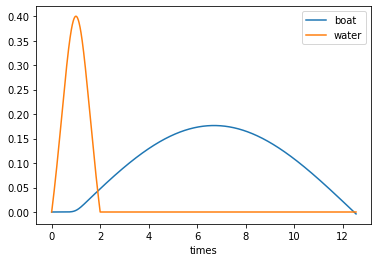

In [7]:
max_angle, df_sim = kaboodle(2, get_df = True)

df_sim['theta_b'].plot(label = "boat")
ts = df_sim.index.tolist()
ws=[]
for t in ts: 
    ws.append(w_func(t))
plt.plot(ts, ws, label = "water")
plt.legend()

To evaluate the full optimization problem, I test a range of values for the shape parameter which don't break my constraints defined above. The following cell runs the simulation for these various hull shape inputs and evaluates the resulting boat angle for each.

In [8]:
angles = []
for n in np.linspace(0.5, 4, 16):
    new = kaboodle(n)
    print(new)
    angles.append(new)

0.31293601184534403
0.26811074372856797
0.2416190089435548
0.21612187763157437
0.20528089284346043
0.18866812394910062
0.1818315889052195
0.17094058554005548
0.16553350860031102
0.15776630139006717
0.1537430555256268
0.14752316366990778
0.14428633944502273
0.13845280882854644
0.1374486924778395
0.13489814235367228


We can visualize this result in the cell below. Interestingly, the relationship seems to never reach a local minimum without the defined constraints. This matches fairly well with my intuition about boat hull shapes - a more square hull translates to a more stable boat. However, I don't have an easy way to validate this assessment. 

Text(0.5, 1.0, 'Angle offset resulting from wave input')

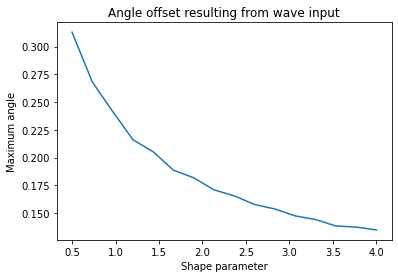

In [9]:
shapes = np.linspace(0.5, 4, 16)
plt.plot(shapes, angles)
plt.xlabel("Shape parameter")
plt.ylabel("Maximum angle")
plt.title("Angle offset resulting from wave input")

## Conclusion
In conclusion, I feel that my model helps me to speak more confidently about what kind of kayak shapes are more stable.  A novice kayaker looking for a more stable float will find comfort and ease on a boat with a more square shape hull. 

Having said this, I have to acknowledge how broad this design space is, and admit that there are many more potential design parameters which should be studied in the future. One that sticks out to me is the fact that we were only concerned with the side to side motion of the kayak, while the majority of the time actually spent in a kayak is spent moving forwards. Things like the complete 3D shape of the hull and other design goals should be explored. Even within the context of the side to side motion, there are several other design parameters that were left untouched. The effects of putting a person in the boat and the effect that this would have on the center of mass could also be explored. 

While, this simple model does a decent job of illustrating the effect of hull shape on a single design choice, more work should be done to develop a boat which accounts for a broader set of design goals. 